## Import Modules

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load the Dataset

In [2]:
TRAIN_DIR = '../input/facial-expression-dataset/train/train/'
TEST_DIR = '../input/facial-expression-dataset/test/test/'

In [3]:
def load_dataset(directory):
    image_paths = []
    labels = []
    
    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)
            
        print(label, "Completed")
        
    return image_paths, labels

In [4]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

surprise Completed
fear Completed
angry Completed
neutral Completed
sad Completed
disgust Completed
happy Completed


,image,label
0,../input/facial-expression-dataset/train/train...,fear
1,../input/facial-expression-dataset/train/train...,happy
2,../input/facial-expression-dataset/train/train...,neutral
3,../input/facial-expression-dataset/train/train...,surprise
4,../input/facial-expression-dataset/train/train...,fear


In [5]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

surprise Completed
fear Completed
angry Completed
neutral Completed
sad Completed
disgust Completed
happy Completed


,image,label
0,../input/facial-expression-dataset/test/test/s...,surprise
1,../input/facial-expression-dataset/test/test/s...,surprise
2,../input/facial-expression-dataset/test/test/s...,surprise
3,../input/facial-expression-dataset/test/test/s...,surprise
4,../input/facial-expression-dataset/test/test/s...,surprise


## Exploratory Data Analysis

<Axes: xlabel='label', ylabel='count'>

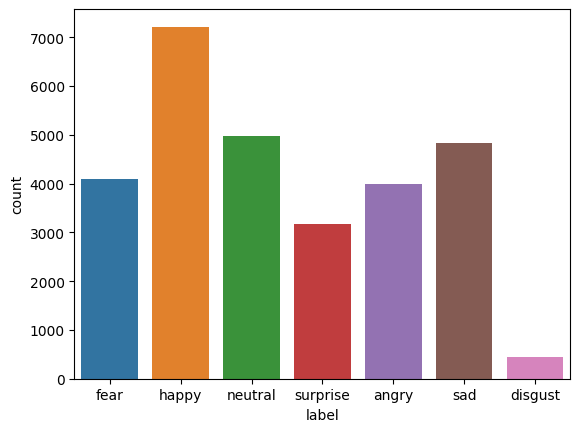

In [6]:
sns.countplot(x=train['label'])

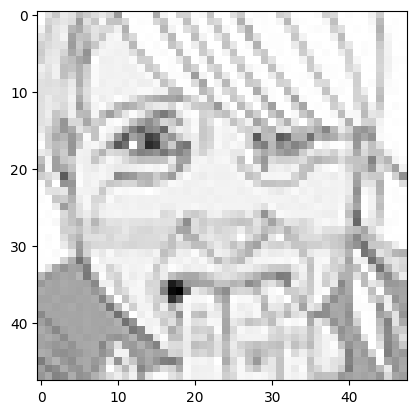

In [7]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray');

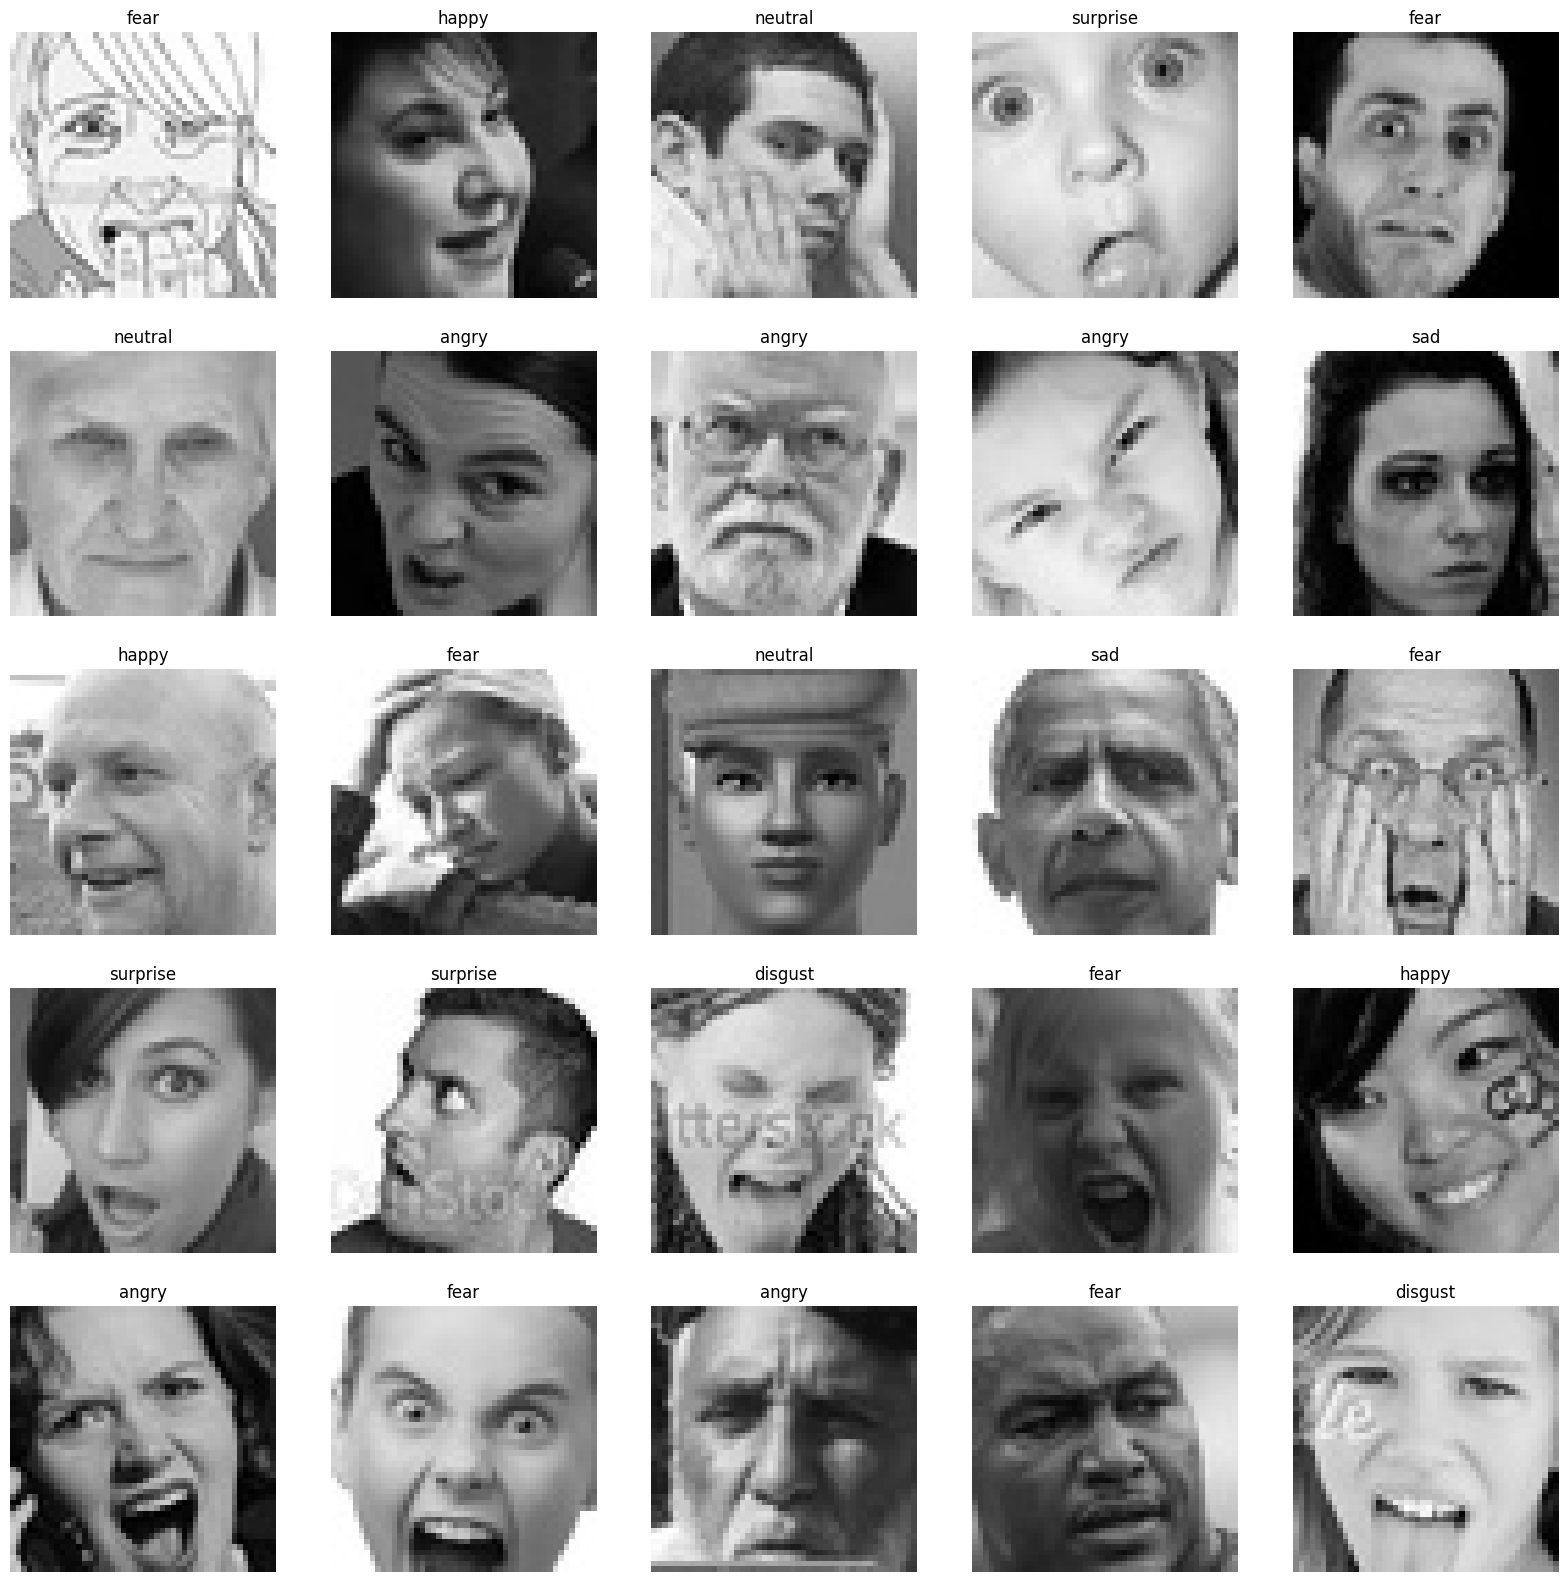

In [8]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

## Feature Extraction

In [9]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

In [10]:
train_features = extract_features(train['image'])

  0%|          | 0/28709 [00:00<?, ?it/s]

In [11]:
test_features = extract_features(test['image'])

  0%|          | 0/7178 [00:00<?, ?it/s]

In [12]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

In [13]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [14]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [15]:
y_train[0]

array([0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [16]:
# config
input_shape = (48, 48, 1)
output_class = 7

## Model Creation

In [17]:
model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(output_class, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [18]:
# train the model
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100


2023-10-09 11:07:26.470596: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


225/225 [==============================] - 25s 55ms/step - loss: 1.8213 - accuracy: 0.2468 - val_loss: 1.7969 - val_accuracy: 0.2483
Epoch 2/100
225/225 [==============================] - 11s 47ms/step - loss: 1.7784 - accuracy: 0.2589 - val_loss: 1.7040 - val_accuracy: 0.2986
Epoch 3/100
225/225 [==============================] - 11s 47ms/step - loss: 1.6944 - accuracy: 0.3117 - val_loss: 1.5629 - val_accuracy: 0.3819
Epoch 4/100
225/225 [==============================] - 11s 48ms/step - loss: 1.5667 - accuracy: 0.3804 - val_loss: 1.4451 - val_accuracy: 0.4476
Epoch 5/100
225/225 [==============================] - 11s 47ms/step - loss: 1.4754 - accuracy: 0.4258 - val_loss: 1.3630 - val_accuracy: 0.4730
Epoch 6/100
225/225 [==============================] - 11s 47ms/step - loss: 1.4229 - accuracy: 0.4508 - val_loss: 1.3291 - val_accuracy: 0.4875
Epoch 7/100
225/225 [==============================] - 11s 48ms/step - loss: 1.3833 - accuracy: 0.4694 - val_loss: 1.3232 - val_accuracy: 0.48

## Plot the Results

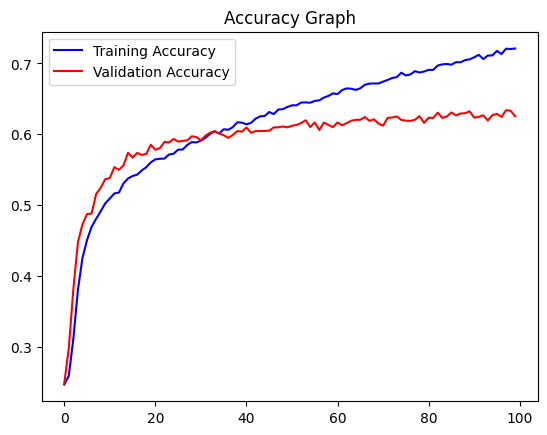

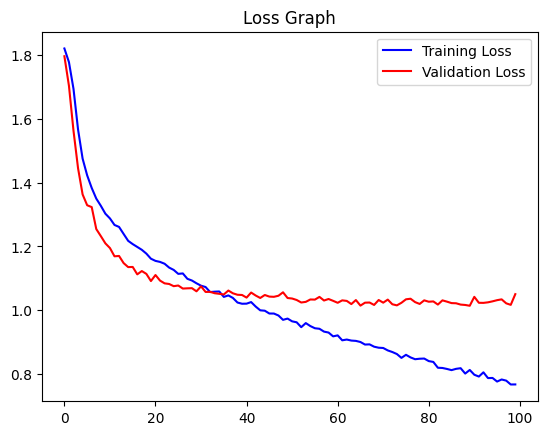

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

Original Output: sad
1/1 [==============================] - 0s 302ms/step
Predicted Output: sad


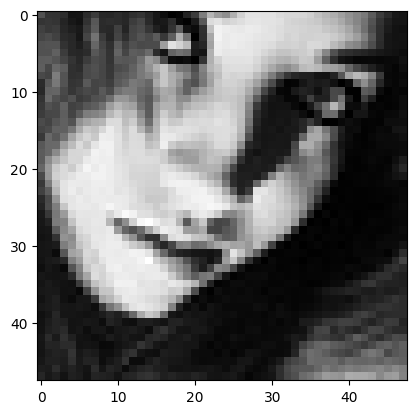

In [20]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: fear
1/1 [==============================] - 0s 20ms/step
Predicted Output: sad


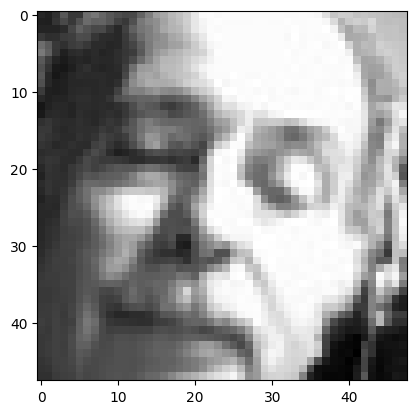

In [21]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: fear
1/1 [==============================] - 0s 20ms/step
Predicted Output: angry


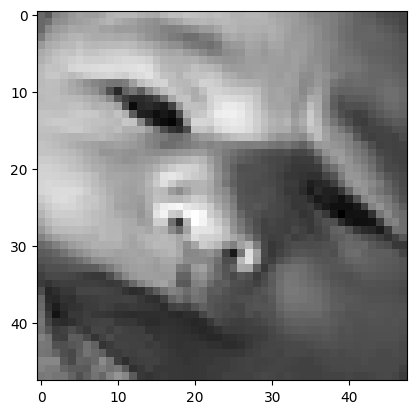

In [22]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');